# Clasificación de imágenes con Tensorflow

## Obtener las clases a predecir

Descargamos sólo un subconjunto

In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2021-08-29 13:10:13--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2021-08-29 13:10:14 (34.3 MB/s) - ‘mini_classes.txt’ saved [760/760]



Leemos el archivo

In [2]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [3]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [4]:
classes

['drums',
 'sun',
 'laptop',
 'anvil',
 'baseball_bat',
 'ladder',
 'eyeglasses',
 'grapes',
 'book',
 'dumbbell',
 'traffic_light',
 'wristwatch',
 'wheel',
 'shovel',
 'bread',
 'table',
 'tennis_racquet',
 'cloud',
 'chair',
 'headphones',
 'face',
 'eye',
 'airplane',
 'snake',
 'lollipop',
 'power_outlet',
 'pants',
 'mushroom',
 'star',
 'sword',
 'clock',
 'hot_dog',
 'syringe',
 'stop_sign',
 'mountain',
 'smiley_face',
 'apple',
 'bed',
 'shorts',
 'broom',
 'diving_board',
 'flower',
 'spider',
 'cell_phone',
 'car',
 'camera',
 'tree',
 'square',
 'moon',
 'radio',
 'hat',
 'pizza',
 'axe',
 'door',
 'tent',
 'umbrella',
 'line',
 'cup',
 'fan',
 'triangle',
 'basketball',
 'pillow',
 'scissors',
 't-shirt',
 'tooth',
 'alarm_clock',
 'paper_clip',
 'spoon',
 'microphone',
 'candle',
 'pencil',
 'envelope',
 'saw',
 'frying_pan',
 'screwdriver',
 'helmet',
 'bridge',
 'light_bulb',
 'ceiling_fan',
 'key',
 'donut',
 'bird',
 'circle',
 'beard',
 'coffee_cup',
 'butterfly',
 

# Descargamos el dataset

Descargamos sólo los datos correspondientes a las clases que tenemos

In [5]:
!mkdir data

In [6]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Importamos las librerías a usar

In [8]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Cargamos los datos

Cada clase contiene diferente número de ejemplos almacenados en formato .npy

In [9]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #inicializamos las variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #cargamos cada archivo de datos
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #generamos el dataset de forma aleatoria
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separamos en entrenamiento y pruebas
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [10]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [11]:
print(len(x_train))

320000


Vemos algún dato de forma aleatoria

hammer


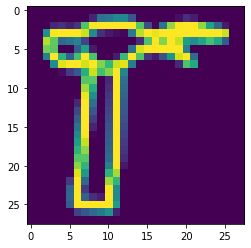

In [12]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocesamos los datos

In [13]:
# Hacemos reshape y normalizamos los datos
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convertimos las clases desde vectores a matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Creamos el modelo

In [14]:
# Definimos el modelo
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 

adam = tf.compat.v1.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

# Hacemos el entrenamiento 

In [15]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 42s - loss: 1.9414 - top_k_categorical_accuracy: 0.7778 - val_loss: 1.3865 - val_top_k_categorical_accuracy: 0.8765
Epoch 2/5
1125/1125 - 12s - loss: 1.2444 - top_k_categorical_accuracy: 0.8929 - val_loss: 1.1617 - val_top_k_categorical_accuracy: 0.9022
Epoch 3/5
1125/1125 - 12s - loss: 1.0831 - top_k_categorical_accuracy: 0.9104 - val_loss: 1.0756 - val_top_k_categorical_accuracy: 0.9105
Epoch 4/5
1125/1125 - 12s - loss: 0.9919 - top_k_categorical_accuracy: 0.9199 - val_loss: 1.0232 - val_top_k_categorical_accuracy: 0.9172
Epoch 5/5
1125/1125 - 12s - loss: 0.9340 - top_k_categorical_accuracy: 0.9257 - val_loss: 0.9663 - val_top_k_categorical_accuracy: 0.9219


# Pruebas 

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: {:0.2f}%'.format(score[1] * 100))

Accuracy: 92.33%


# Inferencia

['ice_cream', 'helmet', 'microphone', 'headphones', 'tennis_racquet']


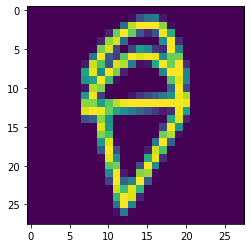

In [19]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Almacenamos las clases

In [20]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Instalamos TensorFlowJS

In [21]:
!pip install tensorflowjs 

     |████████████████████████████████| 64 kB 2.0 MB/s 


# Guardamos y convertimos el modelo

In [22]:
model.save('keras.h5')

In [23]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Compromimos y descargamos el modelo 

In [24]:
!cp class_names.txt model/class_names.txt

In [25]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 84%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/class_names.txt (deflated 41%)


In [ ]:
from google.colab import files
files.download('model.zip')